In [2]:
import sys
sys.path.append('../src/')
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
from utils.visual_functions import *
from utils.utils import *
from utils.data_generator import *
import numpy as np
from sklearn.manifold import TSNE
import tqdm.notebook as tqdm
%matplotlib inline
fig_path="../figure/paper/"
seed = 4783957
print("set seed")
np.random.seed(seed)
import torch
import palettable
from utils.data_generator import get_data, get_loaders
colors =[plt.cm.Blues(0.6), plt.cm.Reds(0.4), plt.cm.Greens(0.6), '#ffcc99', plt.cm.Greys(0.6)]
plaid_names = ['CFL','ILB','Waterkettle','Fan','AC','HairIron','LaptopCharger','SolderingIron','Fridge','Vacuum','CoffeeMaker','FridgeDefroster']
sns.set_color_codes("pastel")

set seed


In [3]:
def fryze_power_decomposition(i, v, T=500):
    #pact = i[:,None]*v[:, None]
    #pact = np.sum(pact)/T
    #vrms = np.sum(v[:,None]**2)/T
    p    = i*v
    vrsm = v**2
    i_active=p.mean()*v/vrsm.mean()  
    i_non_active = i- i_active 
    return i_active, i_non_active 

In [4]:
def get_components(i, v):
    dv = np.gradient(v)
    dvrms = np.mean(dv**2)
    p = np.mean(i*v)
    pdv = np.mean(i*dv)
    vrms = np.mean(v**2)
    i_a = p*v/vrms
    i_f = i - i_a
    
    i_r = pdv*dv/dvrms
    i_s = i - i_r
    
    return i_a, i_f, i_r, i_s



### Functions

In [5]:
def calculatePower(train_current, train_voltage, NN=500):
  

    n = len(current)
    PQ = np.empty([n,2])
    for i in range(n):
        # extract current and voltage in two cycle
        # extract current and voltage in two cycle
        temp_I = current[i]
        temp_V = voltage[i]
        Irms = np.mean(temp_I**2)**0.5
        Vrms = np.mean(temp_V**2)**0.5

        # Instantaneous power: obtained by multiplying the instantaneous voltage and current values
        Pinst = temp_I * temp_V
        Pactive = np.mean(Pinst) 

        # Apparent power: obtained by multiplying the RMS values of voltage and current
        Papparent = Vrms*Irms;

        # Ractive power if power triangle holds:
        Preactive = np.sqrt(Papparent**2 - Pactive**2);




        PQ[i,0]=Pactive
        PQ[i,1]=Preactive
    return PQ



In [6]:
def plot_PQPlane(labels, PQ, legends=None, sample=True):
    
    if legends:
        Legends=legends
    else:
        Legends=np.unique(labels)
        
    clrs = sns.color_palette("Paired", len(Legends))
    markers='1v^<P4ph+DX*8os3<-'
    
    minx,maxx,miny,maxy = (0,0,0,0)
    

    for i, app in enumerate(Legends):
        ix=np.where(labels==app)[0]
        if sample:
            ix1 = np.random.randint(PQ.shape[0],size=6)
            tempx = PQ[ix1,0]
            tempy = PQ[ix1,1]
        else:
            tempx = PQ[ix,0]
            tempy = PQ[ix,1]
        plt.scatter(tempx,tempy,marker=markers[i], s=30, label=Legends[i], color=clrs[i])
        minx = min(minx,min(tempx))
        maxx = max(maxx,max(tempx))
        miny = min(miny,min(tempy))
        maxy = max(maxy,max(tempy))    
    plt.axis([minx*0.9,maxx*1.1,miny*0.9,maxy*1.1])
    plt.xlabel('Real Power(W)')
    plt.ylabel('Reactive Power (VAR)')
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()

    
def tsne_visualizer(labels, feature, legends=None):
    if legends:
        Legends=legends
    else:
        Legends=np.unique(labels)
    clrs = sns.color_palette("Paired", len(Legends))
    #model  = TSNE(perplexity=20, min_grad_norm=1E-12, n_iter=500)
    model = TSNE(n_components=2, random_state=0, perplexity=20, n_iter=1000)
    TSNEF  = model.fit_transform(feature.reshape(len(feature), -1))
    
    for i, app in enumerate(Legends):
        ix=np.where(labels==app)[0]
        plt.scatter(TSNEF[ix,0], TSNEF[ix,1],label=app, color=clrs[i])
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.xlabel("tsne-2d-one")
    plt.ylabel("tsne-2d-two")
    
def list_intersection(a, b): 
    a_set = set(a) 
    b_set = set(b) 
    return a_set.intersection(b_set) 



### PLAID

In [25]:
current, voltage, labels, I_max = get_data(data_type="plaid")

Load plaid aggregated data from ../data/plaid/


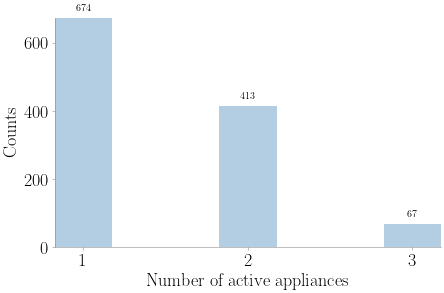

In [13]:
active_apps = np.array([len(set(x)) for x in labels])
l, count=np.unique(active_apps, return_counts=True)
volgorde = np.argsort(count)
fig = figure(fig_width=6)
barwidth = 0.35
plt.bar(np.array(l), count, width=barwidth, color="C1")
plt.xticks(np.array(l), np.array(["1", '2', '3']));
plt.tight_layout()
ax = plt.gca()  
ax.set_ylabel(f'Counts', fontsize=18)
ax.set_xlabel("",fontsize=20)
        
for p in ax.patches:
        #ax.annotate('{:.0%}'.format(height), (p.get_x()+.15*width, p.get_y() + height + 0.01))
        ax.annotate("${}$".format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax.set_xlabel(f'Number of active appliances', fontsize=18)     
ax.tick_params(axis='both', which='major', labelsize=18)
format_axes(ax)
ax.autoscale(tight=True)
#savefig(fig_path+"active_appliances_distribution_plaid",format=".pdf")

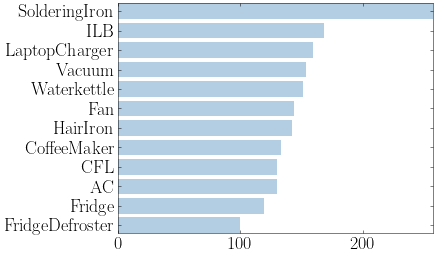

In [12]:
l, count=np.unique(np.hstack(labels), return_counts=True)
volgorde = np.argsort(count)
height = 0.8
fig = figure(fig_width=6)
plt.barh(np.array(l)[volgorde], count[volgorde], height=height,color="C1")
plt.tight_layout()
plt.tight_layout()
ax = plt.gca()  
ax.set_xlabel(f'Counts', fontsize=20)
#ax.set_ylabel(f'Number of active appliances', fontsize=20)
ax.set_xlabel("",fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.autoscale(tight=True)
#savefig(fig_path+"label_distribution_plaid",format=".pdf")

## Extract 

In [27]:
single_labels = []
single_labels_ids = []
for idx, l in enumerate(labels):
    if len(set(l))==1:
        single_labels_ids.append(idx)
        single_labels.append(list(set(l))[0])
unique_label = np.unique(np.hstack(single_labels))    

In [28]:
current_sample = current[single_labels_ids]
voltage_sample = voltage[single_labels_ids]
#decomposed_current=compute_active_non_active_features(current_sample, voltage[single_labels_ids])
#current_feature=generate_input_feature(current_sample, voltage[single_labels_ids], "current", width=50,  p=2)
#decomposed_current_feature=generate_input_feature(current_sample, voltage[single_labels_ids], "decomposed_current", width=50,  p=2)
#decomposed_distance_faeture=generate_input_feature(current_sample, voltage[single_labels_ids], "decomposed_distance", width=50,  p=2)

In [16]:
def min_max_normalize(x):
    max_value = max(abs(x.min()), x.max())
    return x/max_value

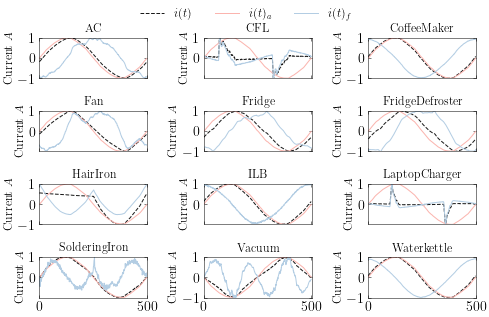

In [18]:
fig, axs = plt.subplots(len(unique_label)//3,3, sharex=True, figsize=set_figure_size(columns=2))
fig.subplots_adjust(hspace = 0.25)
axs = axs.ravel()
for idap, app in enumerate(unique_label):
    idx = np.random.choice(np.where(np.array(single_labels)==app)[0])
    i_a, i_f = fryze_power_decomposition(current_sample[idx], voltage_sample[idx], T=500)
    
    axs[idap].plot(min_max_normalize(current_sample[idx]), "k--", label="$i(t)$")
    axs[idap].plot(min_max_normalize(i_a), label="$i(t)_a$")
    axs[idap].plot(min_max_normalize(i_f), label="$i(t)_f$")
    axs[idap].set_title(app)
    axs[idap].set_ylabel("Current $A$", fontsize=12) 
    axs[idap].set_xlim(0, 501) 
    #format_axes(axs[idap])
    axs[idap].autoscale(tight=True)
    

handles, labels = axs[idap].get_legend_handles_labels()
leg=fig.legend(handles, labels, loc='upper center',  ncol=3, fontsize=12, bbox_to_anchor=(0.5, 1.05))
fig.tight_layout()
#savefig(fig_path+"decomposed_current_plaid",format=".pdf", leg=leg)

In [29]:
single_app  = ['CFL']
double_app  = ["CFL", "LaptopCharger"]
single_lap  = ["LaptopCharger"]
single_kettle = ['Waterkettle']
cfls = []
cfls_laptop = []
laptops   = []
kettles   = []
for idx in range(len(labels)):
    x=list_intersection(single_app, labels[idx])
    if len(x)==1:
        cfls.append(idx)
        
    x=list_intersection(double_app, labels[idx])
    if len(x)==2:
        cfls_laptop.append(idx)
        
    x=list_intersection(single_lap, labels[idx])
    if len(x)==1:
        laptops.append(idx)   
        
    x=list_intersection(single_kettle, labels[idx])
    if len(x)==1:
        kettles.append(idx)   

In [31]:
ones = []
for i, l in enumerate(labels[cfls]):
    if len(l)==1:
        ones.append(i)

In [32]:
current_cfl=generate_input_feature(current[cfls], voltage[cfls], "current", width=50,  p=2)

processed: 100 percent: : 130it [00:01, 65.87it/s]


In [33]:
decomposed_current_cfl=generate_input_feature(current[cfls], voltage[cfls], "decomposed_current", width=50,  p=2)

frze processed: 100 percent: : 130it [00:03, 34.48it/s]
../src/utils/utils.py:140: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  features=torch.tensor(features).float().transpose(1,2)


In [34]:
x=decomposed_current_cfl[:,0,:]**2 + decomposed_current_cfl[:,1,:]**2
x.shape

torch.Size([130, 50])

In [35]:
distance_cfl=generate_input_feature(current[cfls], voltage[cfls], "distance", width=50,  p=2)
vi_cfl=generate_input_feature(current[cfls], voltage[cfls], "vi", width=50,  p=2)

processed: 100 percent: : 130it [00:01, 66.78it/s]
processed: 130: : 130it [00:00, 1031.54it/s]


In [36]:
decomposed_distance_cfl=generate_input_feature(current[cfls], voltage[cfls], "decomposed_distance", width=50,  p=2)
decomposed_vi_cfl=generate_input_feature(current[cfls], voltage[cfls], "decomposed_vi", width=50,  p=2)

frze processed: 100 percent: : 130it [00:03, 34.13it/s]
frze processed: 100 percent: : 130it [00:03, 34.53it/s]
processed: 100 percent: : 130it [00:01, 67.38it/s]
processed: 130: : 130it [00:00, 1424.61it/s]
processed: 130: : 130it [00:00, 1479.20it/s]


In [37]:
model  = TSNE(perplexity=20, min_grad_norm=1E-12, n_iter=10000, random_state=42)
TSNEF  = model.fit_transform(decomposed_current_cfl.reshape(len(decomposed_distance_cfl), -1))

/Users/anthonyfaustine/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/anthonyfaustine/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0, 0.5, 'tsne-2d-two')

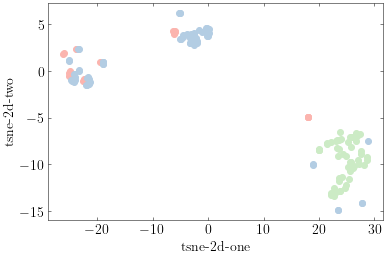

In [38]:
for ix, app in enumerate(labels[cfls]):
    if len(app)==1:
        plt.scatter(TSNEF[ix,0], TSNEF[ix,1], color='C2')
    if len(app)==2:
        plt.scatter(TSNEF[ix,0], TSNEF[ix,1], color='C1')
        
    if len(app)==3:
        plt.scatter(TSNEF[ix,0], TSNEF[ix,1], color='C0')
        
    if len(app)==4:
        plt.scatter(TSNEF[ix,0], TSNEF[ix,1], color='C4')
#plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.xlabel("tsne-2d-one")
plt.ylabel("tsne-2d-two")

In [39]:
fig = figure(fig_width=4)
plt.plot(current_cfl[1][0])
plt.tight_layout()
plt.ylabel("current $A$")
plt.xlabel("sample $w$")
savefig(fig_path+"plaid_event_currents_cfl", format=".pdf")

Text(0.5, 2.3513187654507615, 'sample $w$')

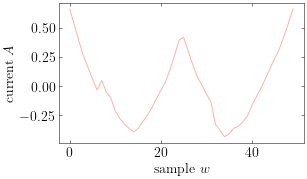

In [40]:
fig = figure(fig_width=4)
plt.plot(decomposed_current_cfl[1][0])
plt.tight_layout()
plt.ylabel("current $A$")
plt.xlabel("sample $w$")
#savefig(fig_path+"plaid_decomposed_currents_active", format=".pdf")

Text(0.5, 2.3513187654507615, 'sample $w$')

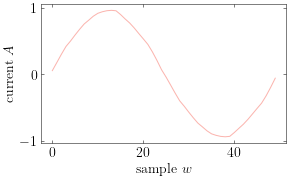

In [41]:
fig = figure(fig_width=4)
plt.plot(decomposed_current_cfl[1][1])
plt.tight_layout()
plt.ylabel("current $A$")
plt.xlabel("sample $w$")
#savefig(fig_path+"plaid_decomposed_currents_non_active", format=".pdf")

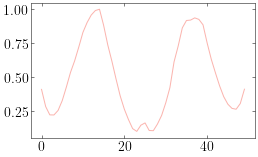

In [42]:
fig = figure(fig_width=4)
x=decomposed_current_cfl[1][1]**2 +decomposed_current_cfl[1][0]**2
x=x/x.max()

plt.plot(x)

In [43]:
fig = figure(fig_width=4)
plt.plot(decomposed_current_cfl[1][1]+decomposed_current_cfl[1][0])
plt.tight_layout()
plt.ylabel("current $A$")
plt.xlabel("sample $w$")
#savefig(fig_path+"plaid_decomposed_currents_non_active_plus_active", format=".pdf")

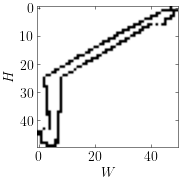

In [44]:
fig = figure(fig_width=2.75, fig_height=2.75)
plt.imshow(vi_cfl[1][0], cmap="Greys")
plt.xlabel("$W$")
plt.ylabel("$H$")
plt.tight_layout()
#savefig(fig_path+"plaid_vi_cfl", format=".pdf")

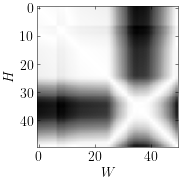

In [45]:
fig = figure(fig_width=2.75, fig_height=2.75)
plt.imshow(distance_cfl[1][0], cmap="Greys")
plt.xlabel("$W$")
plt.ylabel("$H$")
plt.tight_layout()
#savefig(fig_path+"plaid_distance_cfl", format=".pdf")

In [46]:
fig = figure(fig_width=2.75, fig_height=2.75)
plt.imshow(decomposed_distance_cfl[1][0], cmap="Greys")
plt.xlabel("$W$")
plt.ylabel("$H$")
plt.tight_layout()
savefig(fig_path+"plaid_decomposed_distance_cfl_active", format=".pdf")


In [47]:
fig = figure(fig_width=2.75, fig_height=2.75)
plt.imshow(decomposed_distance_cfl[1][1], cmap="Greys")
plt.xlabel("$W$")
plt.ylabel("$H$")
plt.tight_layout()
savefig(fig_path+"plaid_decomposed_distance_cfl_non_active", format=".pdf")

In [48]:
fig = figure(fig_width=2.75, fig_height=2.75)
plt.imshow(decomposed_vi_cfl[1][1], cmap="Greys")
plt.xlabel("$W$")
plt.ylabel("$H$")
plt.tight_layout()
savefig(fig_path+"plaid_decomposed_vi_cfl_non_active", format=".pdf")

In [49]:
fig = figure(fig_width=2.75, fig_height=2.75)
plt.imshow(decomposed_vi_cfl[1][0],cmap="Greys")
plt.xlabel("$W$")
plt.ylabel("$H$")
plt.tight_layout()
savefig(fig_path+"plaid_decomposed_vi_cfl_active", format=".pdf")

In [50]:
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
mlb = MultiLabelBinarizer()
mlb.fit(labels)
y = mlb.transform(labels)